<a href="https://colab.research.google.com/github/afullhart/climateanalogs/blob/main/Figures/Score_2brkpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
%reset -f

In [14]:
!pip install rioxarray
!pip install rasterio
!pip install tifffile
!pip install imagecodecs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 85.9 MB/s eta 0:00:00


In [15]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(1622533,)
(1622533,)
(1622533,)
(1622533,)
(1622533,)
(1622533,)
(1622533,)
(1622533,)
(1622533,)
(1622533,)


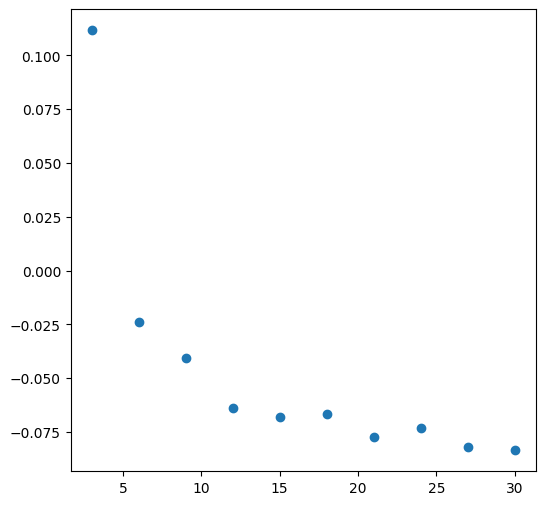

In [16]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from sklearn.metrics import silhouette_samples, silhouette_score
import rasterio
import rioxarray as rx
from PIL import Image
import tifffile
import imagecodecs
import os

comf = '/content/drive/My Drive/Colab Notebooks/Analogs/Extract_Composite.tif'
silhf = '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster_Test'

image = Image.open( '/content/drive/My Drive/Colab Notebooks/Analogs/IsoCluster.tif')
arr = np.asarray(image)
mask = arr > 0

img_array = tifffile.imread(comf)
shp = img_array.shape
new_arr = []
for i in range(shp[2]):
  image = Image.fromarray(img_array[:, :, i]).convert('L')
  arr = np.asarray(image)
  filtered_arr = arr[mask].flatten().tolist()
  new_arr.append(filtered_arr)

new_arr = np.array(new_arr).transpose()

X = new_arr

test_scores = []
test_cluster_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
for n in test_cluster_sizes:

  image = Image.open(os.path.join(silhf, 'IsoCluster_{}.tif'.format(n)))
  arr = np.asarray(image)
  filtered_arr = arr[mask]
  filtered_labels = filtered_arr.flatten()

  cluster_labels = filtered_labels
  print(cluster_labels.shape)
  scores = []
  for rand_sample in [123, 456, 789]:
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000, random_state=rand_sample)
    scores.append(silhouette_avg)

  avg_score = sum(scores)/len(scores)
  test_scores.append(avg_score)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(test_cluster_sizes, test_scores)


/tmp/ipython-input-1994338479.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covar = curve_fit(piecewise_linear, x, y, p0=initial_guess)


6.0
12.0


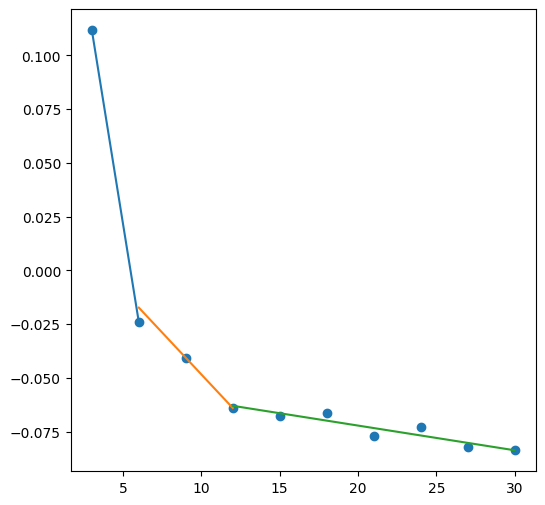

In [17]:
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b1, b2, m1, c1, m2, c2, m3, c3):
  y = np.zeros_like(x)

  mask1 = x <= b1
  y[mask1] = m1 * x[mask1] + c1

  mask2 = (x > b1) & (x <= b2)
  y[mask2] = m2 * x[mask2] + c2

  mask3 = x > b2
  y[mask3] = m3 * x[mask3] + c3
  return y

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint1 = None,
  best_breakpoint2 = None,
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate1 in potential_breakpoints:
    for b_candidate2 in potential_breakpoints:
      try:
        # [breakpoint, slope1, intercept1, slope2, intercept2, slope3, intercept3]
        initial_guess = [b_candidate1, b_candidate2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
        params, covar = curve_fit(piecewise_linear, x, y, p0=initial_guess)
        y_pred = piecewise_linear(x, *params)
        ssr = np.sum((y - y_pred)**2)

        if ssr < min_ssr:
          min_ssr = ssr
          best_breakpoint1, best_breakpoint2  = params[0], params[1]
          best_params = params

      except RuntimeError:
        # Handle cases where curve_fit might fail to converge for a given breakpoint
        print('RuntimeError for case {}'.format(b_candidate1, b_candidate2))
        continue

  return best_breakpoint1, best_breakpoint2, best_params

#fitted_b1, fitted_b2, fitted_a1, fitted_c1, fitted_a2, fitted_c2, fitted_a3, fitted_c3 = popt

x_data = np.array([float(x) for x in test_cluster_sizes])
y_data = np.array([float(x) for x in test_scores])

optimal_b1, optimal_b2, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, b2, m1, c1, m2, c2, m3, c3 = optimal_params

print(optimal_b1)
print(optimal_b2)

# You can then use optimal_params to make predictions or visualize the fit
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, b2], [m2*b1 + c2, m2*b2 + c2])
ax.plot([b2, max(x_data)], [m3*b2 + c3, m3*max(x_data) + c3])


['Zonal_eco3_3.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_9.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_15.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_21.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_27.csv', 'Zonal_eco3_30.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,377798,73280,2991,6710,121925,3899,168135,12025,51528,2,393,302,7229,54036,101663
1,2,9679,483,566,1933,2590,1559,14459,44091,47927,45719,97738,0,41079,476,22636
2,3,57172,2650,978,57196,24065,34197,15460,99838,709,0,3084,1096,5956,7247,8


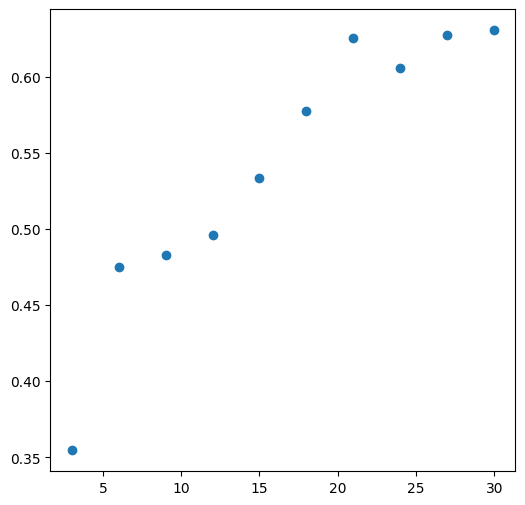

In [8]:

'https://stats.stackexchange.com/questions/95731/how-to-calculate-purity'

fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_dict = {}
for key in keys:
  sorted_dict[key] = df_dict[key]

purity_list = []
for key in sorted_dict:
  df = sorted_dict[key]
  sum = df.iloc[:, 1:].sum().sum()
  max_values_per_row = df.iloc[:, 1:].max(axis=1)
  purity = max_values_per_row.sum()/sum
  purity_list.append(purity)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, purity_list)



/tmp/ipython-input-499577088.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covar = curve_fit(piecewise_linear, x, y, p0=initial_guess)


6.0
21.0


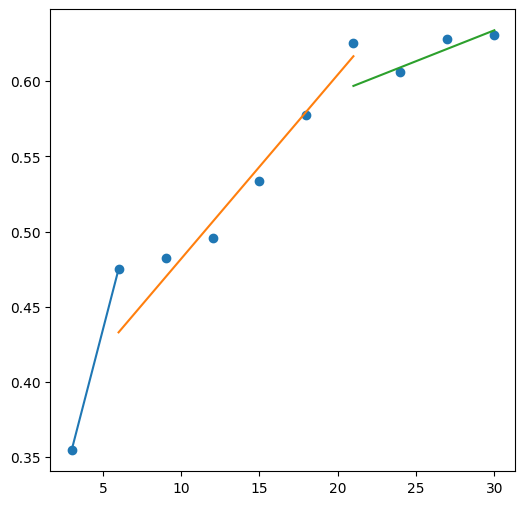

In [9]:
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b1, b2, m1, c1, m2, c2, m3, c3):
  y = np.zeros_like(x)

  mask1 = x <= b1
  y[mask1] = m1 * x[mask1] + c1

  mask2 = (x > b1) & (x <= b2)
  y[mask2] = m2 * x[mask2] + c2

  mask3 = x > b2
  y[mask3] = m3 * x[mask3] + c3
  return y

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint1 = None,
  best_breakpoint2 = None,
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate1 in potential_breakpoints:
    for b_candidate2 in potential_breakpoints:
      try:
        # [breakpoint, slope1, intercept1, slope2, intercept2, slope3, intercept3]
        initial_guess = [b_candidate1, b_candidate2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
        params, covar = curve_fit(piecewise_linear, x, y, p0=initial_guess)
        y_pred = piecewise_linear(x, *params)
        ssr = np.sum((y - y_pred)**2)

        if ssr < min_ssr:
          min_ssr = ssr
          best_breakpoint1, best_breakpoint2  = params[0], params[1]
          best_params = params

      except RuntimeError:
        # Handle cases where curve_fit might fail to converge for a given breakpoint
        print('RuntimeError for case {}'.format(b_candidate1, b_candidate2))
        continue

  return best_breakpoint1, best_breakpoint2, best_params

#fitted_b1, fitted_b2, fitted_a1, fitted_c1, fitted_a2, fitted_c2, fitted_a3, fitted_c3 = popt

x_data = np.array([float(x) for x in keys])
y_data = np.array([float(x) for x in purity_list])

optimal_b1, optimal_b2, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, b2, m1, c1, m2, c2, m3, c3 = optimal_params

print(optimal_b1)
print(optimal_b2)

# You can then use optimal_params to make predictions or visualize the fit
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, b2], [m2*b1 + c2, m2*b2 + c2])
ax.plot([b2, max(x_data)], [m3*b2 + c3, m3*max(x_data) + c3])



['Zonal_eco3_3.csv', 'Zonal_eco3_6.csv', 'Zonal_eco3_9.csv', 'Zonal_eco3_12.csv', 'Zonal_eco3_15.csv', 'Zonal_eco3_18.csv', 'Zonal_eco3_21.csv', 'Zonal_eco3_24.csv', 'Zonal_eco3_27.csv', 'Zonal_eco3_30.csv']


,LABEL,US_L3_13,US_L3_14,US_L3_18,US_L3_19,US_L3_20,US_L3_21,US_L3_22,US_L3_23,US_L3_24,US_L3_25,US_L3_26,US_L3_5,US_L3_79,US_L3_80,US_L3_81
0,1,377798,73280,2991,6710,121925,3899,168135,12025,51528,2,393,302,7229,54036,101663
1,2,9679,483,566,1933,2590,1559,14459,44091,47927,45719,97738,0,41079,476,22636
2,3,57172,2650,978,57196,24065,34197,15460,99838,709,0,3084,1096,5956,7247,8


/tmp/ipython-input-1262452321.py:33: RuntimeWarning: divide by zero encountered in log2
  sr = sr.apply(lambda x: x*np.log2(x))
/tmp/ipython-input-1262452321.py:33: RuntimeWarning: invalid value encountered in scalar multiply
  sr = sr.apply(lambda x: x*np.log2(x))


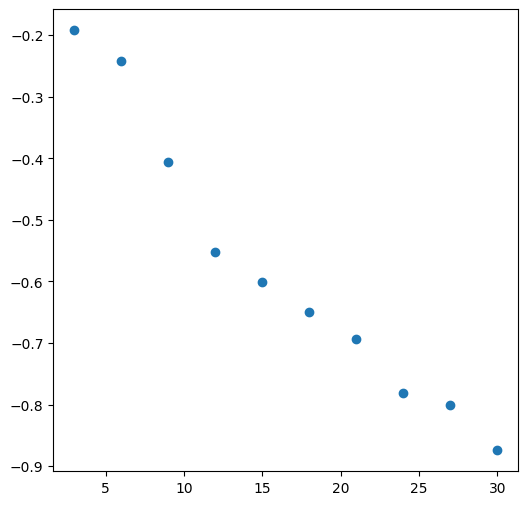

In [10]:
fld = '/content/drive/My Drive/Colab Notebooks/Analogs/Zonal_Test'

files = [f for f in os.listdir(fld) if f[-4:] == '.csv']
print(files)

df = pd.read_csv(os.path.join(fld, files[0]))
display(df)

df_dict = {}
for f in files:
  df = pd.read_csv(os.path.join(fld, f))
  n_classes = len(df)
  df_dict[n_classes] = df

keys = []
for key in df_dict:
  keys.append(key)

keys = sorted(keys)
sorted_dict = {}
for key in keys:
  sorted_dict[key] = df_dict[key]

entropy_list = []
for key in sorted_dict:
  sorted_dict[key] = df_dict[key]
  df = sorted_dict[key]
  df_sum = df.iloc[:, 1:].sum().sum()
  sum_values_per_col = df.iloc[:, 1:].sum(axis=0)
  entropy = 0
  for i, col_sum in enumerate(sum_values_per_col[:1]):
    sr = df.iloc[:, i+1].divide(col_sum)
    sr = sr.apply(lambda x: x*np.log2(x))
    entropy_sum = sr.sum()
    col_entropy = entropy_sum * (col_sum/df_sum)
    entropy += col_entropy

  entropy_list.append(entropy)


fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(keys, entropy_list)



/tmp/ipython-input-2779366581.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covar = curve_fit(piecewise_linear, x, y, p0=initial_guess)


6.0
12.0


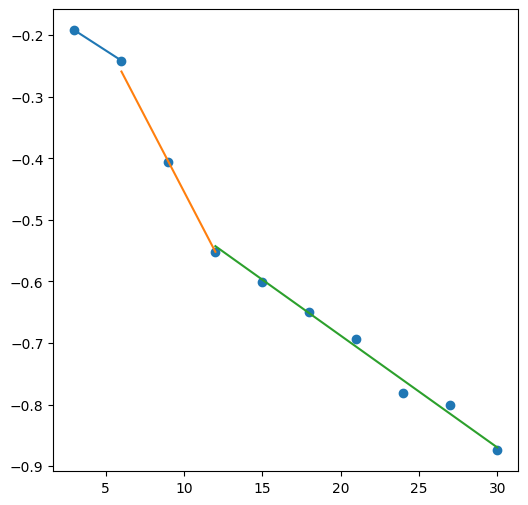

In [11]:
import numpy as np
from scipy.optimize import curve_fit

def piecewise_linear(x, b1, b2, m1, c1, m2, c2, m3, c3):
  y = np.zeros_like(x)

  mask1 = x <= b1
  y[mask1] = m1 * x[mask1] + c1

  mask2 = (x > b1) & (x <= b2)
  y[mask2] = m2 * x[mask2] + c2

  mask3 = x > b2
  y[mask3] = m3 * x[mask3] + c3
  return y

def find_optimal_breakpoint(x, y, num_breakpoints=100):
  min_ssr = np.inf  # Initialize minimum sum of squared residuals
  best_breakpoint1 = None,
  best_breakpoint2 = None,
  best_params = None
  potential_breakpoints = np.linspace(x.min(), x.max(), num_breakpoints)

  for b_candidate1 in potential_breakpoints:
    for b_candidate2 in potential_breakpoints:
      try:
        # [breakpoint, slope1, intercept1, slope2, intercept2, slope3, intercept3]
        initial_guess = [b_candidate1, b_candidate2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
        params, covar = curve_fit(piecewise_linear, x, y, p0=initial_guess)
        y_pred = piecewise_linear(x, *params)
        ssr = np.sum((y - y_pred)**2)

        if ssr < min_ssr:
          min_ssr = ssr
          best_breakpoint1, best_breakpoint2  = params[0], params[1]
          best_params = params

      except RuntimeError:
        # Handle cases where curve_fit might fail to converge for a given breakpoint
        print('RuntimeError for case {}'.format(b_candidate1, b_candidate2))
        continue

  return best_breakpoint1, best_breakpoint2, best_params

#fitted_b1, fitted_b2, fitted_a1, fitted_c1, fitted_a2, fitted_c2, fitted_a3, fitted_c3 = popt

x_data = np.array([float(x) for x in keys])
y_data = np.array([float(x) for x in entropy_list])

optimal_b1, optimal_b2, optimal_params = find_optimal_breakpoint(x_data, y_data)
b1, b2, m1, c1, m2, c2, m3, c3 = optimal_params

print(optimal_b1)
print(optimal_b2)

# You can then use optimal_params to make predictions or visualize the fit
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x_data, y_data)
ax.plot([min(x_data), b1], [m1*min(x_data) + c1, m1*optimal_b1 + c1])
ax.plot([b1, b2], [m2*b1 + c2, m2*b2 + c2])
ax.plot([b2, max(x_data)], [m3*b2 + c3, m3*max(x_data) + c3])
